# Date-a-Scientist Machine Learning Project: Predicting Users' Zodiac Sign Based on Dating Profile Data?

Many dating app users like to know other users' sun/zodiac signs. However, unfortunately many users fail to fill in this piece of their profile. Therefore, I will attempt to build a machine learning classifier that will predict a user's sun sign based on other pieces of data from their dating app profile.

### Objectives:
1. Examine, clean, and process data for use in machine learning model.
2. Familiarize myself with and practice using SciKit Learn's machine learning modules.
3. Use classifiers such as Decision Tree and Random Forest to predict zodiac sign from various categorical variables.
3. Use Naive Bayes Classifier and Natural Language Processing (NLP) to predict zodiac sign based on user profile essays.

In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import confusion_matrix, classification_report
from bs4 import BeautifulSoup

In [118]:
profiles = pd.read_csv('profiles.csv')
profiles['sign_cleaned'] = profiles.sign.str.split(' ').str[0]
profiles['religion_cleaned'] = profiles.religion.str.split(' ').str[0]
profiles['elements'] = profiles.sign_cleaned.map({'leo': 'fire', 'sagittarius': 'fire', 
                                                  'aries': 'fire', 'taurus': 'earth',
                                                  'virgo': 'earth', 'capricorn': 'earth', 
                                                  'pisces': 'water', 'scorpio': 'water',
                                                  'cancer': 'water', 'libra': 'air', 
                                                  'aquarius': 'air', 'gemini': 'air'})

print(profiles.info())
print(profiles.isna().sum()/59946)
print(profiles.sign_cleaned.value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               59946 non-null  int64  
 1   body_type         54650 non-null  object 
 2   diet              35551 non-null  object 
 3   drinks            56961 non-null  object 
 4   drugs             45866 non-null  object 
 5   education         53318 non-null  object 
 6   essay0            54458 non-null  object 
 7   essay1            52374 non-null  object 
 8   essay2            50308 non-null  object 
 9   essay3            48470 non-null  object 
 10  essay4            49409 non-null  object 
 11  essay5            49096 non-null  object 
 12  essay6            46175 non-null  object 
 13  essay7            47495 non-null  object 
 14  essay8            40721 non-null  object 
 15  essay9            47343 non-null  object 
 16  ethnicity         54266 non-null  object

Some columns, for instance, religion and diet, are around 30%-40% missing values. However, the dataframe is quite large, with nearly 60,000 entries, therefore, I will simply drop missing value rows as needed depending on analysis/machine learning in the following cells.

Additionally, I cleaned and simplified the strings of the "religion" and "sign" columns in preparation for analysis and machine learning.

# Building Random Forest and Decision Tree Classifiers

In [119]:
profiles_dropped_NaN = profiles[['body_type', 'diet', 'drinks', 'drugs', 'education', 
                          'job', 'orientation', 'pets', 'religion_cleaned',
                          'sex', 'smokes', 'status', 'sign_cleaned', 'elements']].dropna()

features = profiles_dropped_NaN[['body_type', 'diet', 'drinks', 'drugs', 'education', 
                          'job', 'orientation', 'pets', 'religion_cleaned',
                          'sex', 'smokes', 'status']]

target = profiles_dropped_NaN[['sign_cleaned']]

#Encode features and labels (aka target) using OrdinalEncoder and LabelEncoder
oe = OrdinalEncoder()
oe.fit(features)
features_encoded = oe.transform(features)

le = LabelEncoder()
le.fit(target)
target_encoded = le.transform(target)

#SelectKBest function used to perform chi2 test of independency and select features associated with sun sign
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(features_encoded, target_encoded)
features_fs = fs.transform(features_encoded)

selected_features = []
for i in range(len(fs.pvalues_)):
    print(features.columns[i] + " p_value = " + str(fs.pvalues_[i]))
    if fs.pvalues_[i] < 0.05:
        selected_features.append(i)

#Select features with chi2 pvalue less than 0.05
data = features.iloc[:, selected_features]

#Encode selected features using binary encoding and create labels variable
data = pd.get_dummies(data=data, columns=data.columns)
labels = target

#Randomly split data into training and testing groups
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=1)

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


body_type p_value = 0.0014887883186500812
diet p_value = 0.0011976121990489616
drinks p_value = 0.9983924963770244
drugs p_value = 0.14620576590166995
education p_value = 0.007214314047871199
job p_value = 3.4572769938834145e-05
orientation p_value = 0.9999154452565686
pets p_value = 0.8637019119662785
religion_cleaned p_value = 0.06888109277597956
sex p_value = 0.5570842356724738
smokes p_value = 0.01860742035487315
status p_value = 0.9999619291834014


In order to identify features (columns) most likely to be successful to a machine learning classifier in predicting sun/zodiac sign, I performed a chi-square test of independence on a variety of categorical features (columns listed in chi_selection variable above) excluding the essay columns (perform NLP on essay columns later in this document).

Columns subjected to chi2 analysis were selected based on proportion of available data (this is why "offspring" column was excluded, as nearly 60% of the data is missing) as well as the number of categories (ie "speaks", "ethnicity", "location", etc. were excluded due to the large number of different categories).

Data was then split 80% training data and 20% testing data in preparation for building the classifier's below.

In [120]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
print("Random Forest Classifier accuracy = " + str(random_forest.score(X_test, y_test)))

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
print("Decision Tree Classifier accuracy = " + str(tree.score(X_test, y_test)))

print("Random Guess (ie, 1/12 since there are 12 zodiac signs) = " + str(1/12))

/var/folders/wp/8ln6f3ln26l_mhwbv0nvg5440000gn/T/ipykernel_1156/934375540.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_train)


Random Forest Classifier accuracy = 0.08234540211470683
Decision Tree Classifier accuracy = 0.08170458186478692
Random Guess (ie, 1/12 since there are 12 zodiac signs) = 0.08333333333333333


The classifier performed extremely poorly - no better than random guessing. It appears this data is NOT sufficient to predict users' zodiac signs. Perhaps there isn't enough data to define 12 different categories such that accurate predictions can be made. If this is the case, perhaps if I categorize each of the 12 zodiac into their appropriate element the classifier will be able to predict a user's element. There are four elements and three zodiac in each element.

In [121]:
#element labels, signs have been categorized into their appropriate element - water, earth, fire, or air
element_labels = profiles_dropped_NaN[['elements']]

#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, element_labels, random_state=2)

In [122]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
print("Random Forest Classifier accuracy = " + str(random_forest.score(X_test, y_test)))

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
print("Decision Tree Classifier accuracy = " + str(tree.score(X_test, y_test)))

print("Random Guess (ie, 1/4 since there are 4 elements) = " + str(1/4))

/var/folders/wp/8ln6f3ln26l_mhwbv0nvg5440000gn/T/ipykernel_1156/2569292213.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_train)


Random Forest Classifier accuracy = 0.2531239987183595
Decision Tree Classifier accuracy = 0.24959948734380005
Random Guess (ie, 1/4 since there are 4 elements) = 0.25


Again, the classifiers did no better than random guessing even when the number of categories was reduced down to 4 from 12. It appears this data is insufficient to even predict users' element. Below is a confusion matrix and classification report, which includes precision, recall, and f1-score, for the random forest classifier above.

In [123]:
y_pred_test = random_forest.predict(X_test)
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

[[194 191 198 186]
 [194 178 187 200]
 [193 186 203 203]
 [192 193 208 215]]
              precision    recall  f1-score   support

         air       0.25      0.25      0.25       769
       earth       0.24      0.23      0.24       759
        fire       0.26      0.26      0.26       785
       water       0.27      0.27      0.27       808

    accuracy                           0.25      3121
   macro avg       0.25      0.25      0.25      3121
weighted avg       0.25      0.25      0.25      3121



The confusion matrix reveals that the random forest model is not able to successfully predict ANY of the elements (numbers along the diagonal from top left to bottom right are correct classifications). Precision, recall, f1-score, and accuracy reflect the results of the confusion matrix.

# NLP and Building Naive Bayes Classifier

In [124]:
nlp_data = profiles[['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6',
                     'essay7', 'essay8', 'essay9', 'sign_cleaned']].dropna().reset_index()

nlp_essays = nlp_data[['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6',
                     'essay7', 'essay8', 'essay9']].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)

corpus = nlp_essays.apply(lambda x: BeautifulSoup(x).get_text())
corpus = corpus.replace(r'\r+|\n+|\t+',' ', regex=True)

labels = nlp_data[['sign_cleaned']]

print(corpus)

0        about me: i would love to think that i was som...
1        i'm an australian living in san francisco, but...
2        my names jake. i'm a creative guy and i look f...
3        update: i'm seeing someone, so off the market ...
4        i was born in wisconsin, grew up in iowa, and ...
                               ...                        
26112    vibrant, expressive, caring optimist. i love b...
26113    i'm nick. i never know what to write about mys...
26114    hello! i enjoy traveling, watching movies, and...
26115    "all i have in this world are my balls and my ...
26116    is it odd that having a little "enemy" status ...
Length: 26117, dtype: object


In this first step I cleaned all of the essays: I removed all line breaks (/n) as well as removed all html tags that were in the text.

In [125]:
X_train, X_test, y_train, y_test = train_test_split(corpus, labels, random_state=3)

from sklearn.feature_extraction.text import CountVectorizer
counter = CountVectorizer()
counter.fit(X_train)

train_counts = counter.transform(X_train)
test_counts = counter.transform(X_test)

from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(train_counts, y_train)

print(classifier.score(test_counts, y_test))

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.08330781010719755


The Naive Bayes classifier performs just as poorly as the Random Forest and Tree classifiers in the previous section.

sign_cleaned
leo             0.088410
gemini          0.088027
libra           0.087989
cancer          0.086381
virgo           0.085117
taurus          0.083853
scorpio         0.083394
aries           0.083011
sagittarius     0.081977
pisces          0.079910
aquarius        0.079488
capricorn       0.072443
dtype: float64


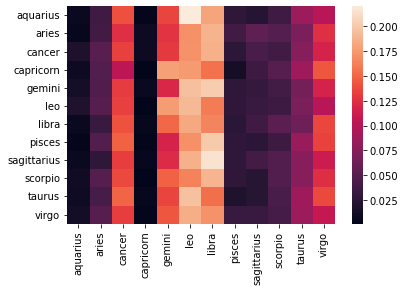

              precision    recall  f1-score   support

    aquarius       0.06      0.01      0.01       556
       aries       0.08      0.04      0.05       561
      cancer       0.08      0.13      0.10       546
   capricorn       0.03      0.00      0.00       435
      gemini       0.08      0.12      0.10       597
         leo       0.09      0.19      0.12       576
       libra       0.08      0.16      0.11       581
      pisces       0.08      0.03      0.04       530
 sagittarius       0.09      0.04      0.06       524
     scorpio       0.09      0.05      0.06       541
      taurus       0.09      0.09      0.09       527
       virgo       0.08      0.11      0.09       556

    accuracy                           0.08      6530
   macro avg       0.08      0.08      0.07      6530
weighted avg       0.08      0.08      0.07      6530



In [134]:
predictions = classifier.predict(test_counts)

print(labels.value_counts(normalize=True))

matrix = confusion_matrix(y_test, predictions, normalize='true')

tick_labels = ['aquarius', 'aries', 'cancer', 'capricorn', 
               'gemini', 'leo', 'libra', 'pisces', 
               'sagittarius', 'scorpio', 'taurus', 'virgo']

ax = sns.heatmap(matrix)
ax.xaxis.set_ticklabels(tick_labels)
plt.xticks(rotation=90)
ax.yaxis.set_ticklabels(tick_labels)
plt.yticks(rotation=0)
plt.show()

print(classification_report(y_test, predictions))

I've provided the proportion that each zodiac sign makes up in the training data. Each sign is fairly equally represented, with leo being somewhat overrepresented and capricorn being underrepresented.

The confusion matrix is represented here as a heatmap. The columns represent the predictions made by the classifier, and the rows represent the true/target signs (y_test). The number of predictions made by the classifier have been normalized across each row. 

For instance, looking at the first row (aquarius row), the classifier most often classified aquarius as gemini, leo, or libra (light squares, meaning higher percentage of total guesses for aquarius samples in y_test), and was least likely to classify aquarius as aquarius, capricorn, pisces, or sagittarius (dark squares, meaning lower percentage of total guesses for aquarius samples in y_test). This observation makes sense given that leo, gemini, and libra are the most represented signs in the training data and aquarius, capricorn, pisces, and sagittarius are least represented. This model suffers from overfitting.

It appears that the data in the essays isn't sufficient for a Naive Bayes classifier to classify zodiac signs.

# Conclusions:

1. Gained practice with examining and cleaning datasets: including practice with NLP and handling missing values.
2. Familiarized myself with and practiced using SciKit Learn's machine learning modules. Also practiced evaluating models using SciKit Learn's classification report and confusion matrix.
3. Random Forest and Decision Tree classifiers were NOT able to predict the zodiac sign of profiles based on question responses. The classifiers remained unsuccessful even when trying to predict just the element of a sign rather than the sign itself.
3. Naive Bayes classifier was NOT able to predict zodiac sign based on profile essays.

### Future Directions:
Based on the unsuccessful results presented here, it would be interesting to further explore if it's possible to predict an individual's zodiac sign from personality data. Given the extremely poor performance of the classifiers used in this paper, it appears there is little to no association between dating profile information and zodiac signs.